<a href="https://colab.research.google.com/github/Bagito999/Testing/blob/main/Deep_Computer_Vision_Using_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Persiapan

In [ ]:
# Cek versi dan lingkungan
import sys, os, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn, tensorflow as tf
from tensorflow import keras

assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= "0.20"
assert tf.__version__ >= "2.0"

# Cek lingkungan Colab / Kaggle dan GPU
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if not tf.config.list_physical_devices('GPU'):
    print("No GPU detected. CNNs can be slow.")
    if IS_COLAB: print("Aktifkan GPU: Runtime > Change runtime type.")
    if IS_KAGGLE: print("Aktifkan GPU: Settings > Accelerator.")

# Set seed untuk reproduktifitas
np.random.seed(42)
tf.random.set_seed(42)

# Konfigurasi plot
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Path penyimpanan gambar
IMAGES_PATH = os.path.join(".", "images", "cnn")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, ext="png", dpi=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{ext}")
    print("Saving figure", fig_id)
    if tight_layout: plt.tight_layout()
    plt.savefig(path, format=ext, dpi=dpi)

def plot_image(img, color=False):
    cmap = None if color else "gray"
    plt.imshow(img, cmap=cmap, interpolation="nearest")
    plt.axis("off")


#Apa itu convolution

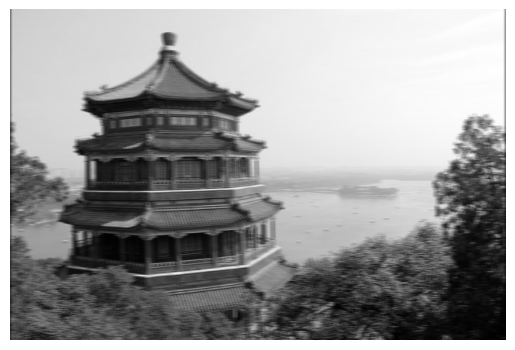

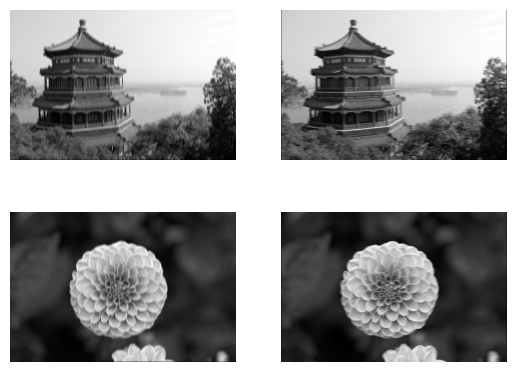

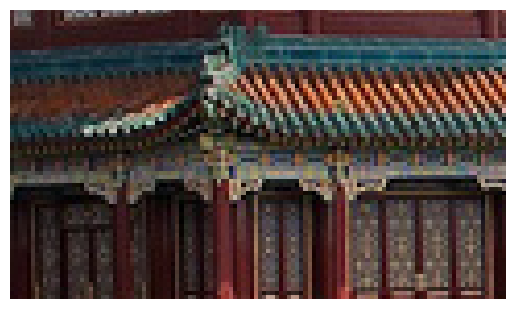

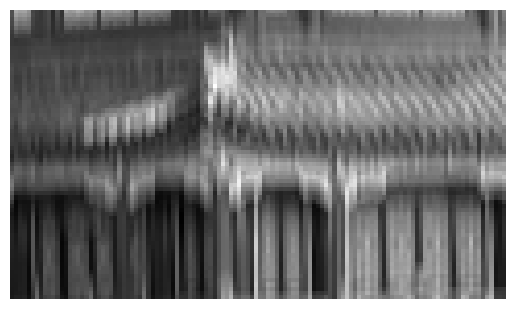

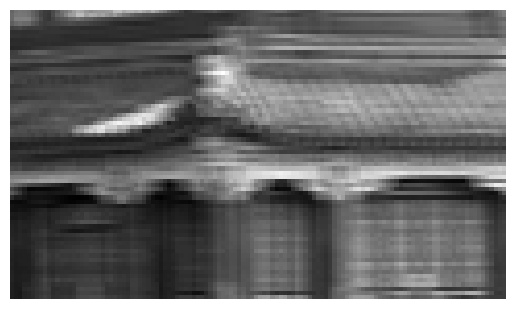

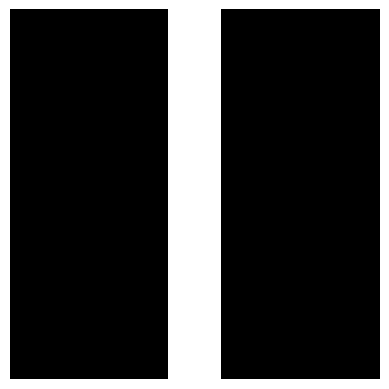

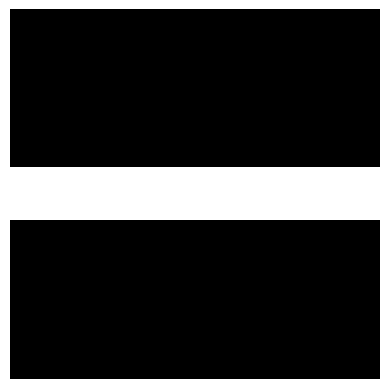

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_sample_image

# Load dan normalisasi gambar contoh
images = np.array([
    load_sample_image("china.jpg") / 255.0,
    load_sample_image("flower.jpg") / 255.0
], dtype=np.float32)

# Buat filter konvolusi: vertikal & horizontal line detectors
filters = np.zeros((7, 7, 3, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertikal
filters[3, :, :, 1] = 1  # horizontal

# Konvolusi 2D
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# Tampilkan feature map dari gambar pertama (horizontal)
plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

# Tampilkan semua hasil feature map
for img_idx in range(2):
    for fmap_idx in range(2):
        plt.subplot(2, 2, img_idx * 2 + fmap_idx + 1)
        plt.imshow(outputs[img_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")
plt.show()

# Fungsi crop gambar
def crop(img): return img[150:220, 130:250]

# Tampilkan crop dari gambar asli dan hasil filter
plt.imshow(crop(images[0]), cmap="gray")
plt.axis("off")
plt.show()

for i in range(2):
    plt.imshow(crop(outputs[0, :, :, i]), cmap="gray")
    plt.axis("off")
    plt.show()

# Tampilkan bentuk filter
for i in range(2):
    plt.imshow(filters[:, :, 0, i], cmap="gray")
    plt.axis("off")
    plt.show()


#Convolutional Layer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


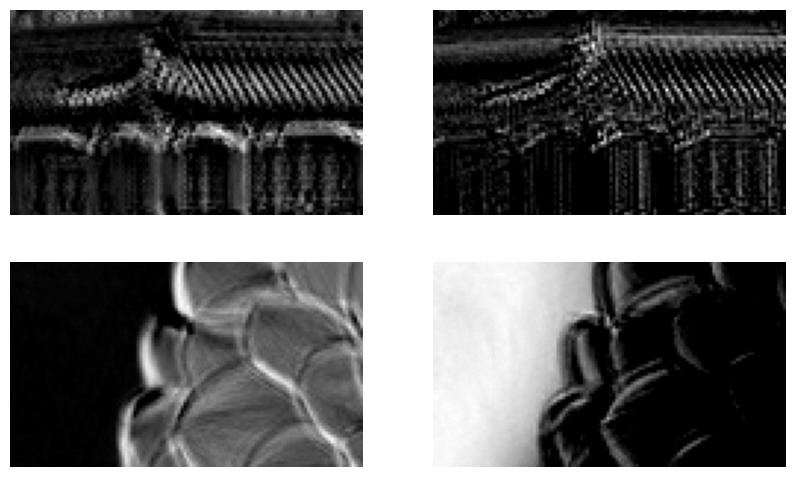

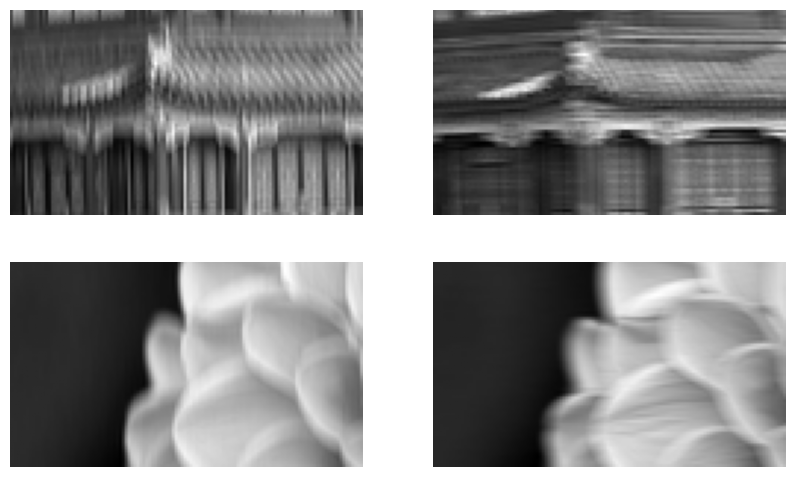

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Seed
np.random.seed(42)
tf.random.set_seed(42)

# Layer konvolusi dengan ReLU
conv = keras.layers.Conv2D(2, kernel_size=7, padding="SAME", activation="relu", input_shape=images.shape[1:])
conv_outputs = conv(images)

# Visualisasi hasil konvolusi (sebelum set_weights)
plt.figure(figsize=(10, 6))
for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, i * 2 + j + 1)
        plt.imshow(crop(conv_outputs[i, :, :, j]), cmap="gray")
        plt.axis("off")
plt.show()

# Set bobot layer konvolusi secara manual
conv.set_weights([filters, np.zeros(2)])
conv_outputs = conv(images)

# Visualisasi setelah set_weights
plt.figure(figsize=(10, 6))
for i in range(2):
    for j in range(2):
        plt.subplot(2, 2, i * 2 + j + 1)
        plt.imshow(crop(conv_outputs[i, :, :, j]), cmap="gray")
        plt.axis("off")
plt.show()

# Fungsi bantu menghitung padding SAMA secara manual
def manual_same_padding(imgs, ksize, stride=1):
    if ksize == 1: return imgs.astype(np.float32)
    b, h, w, c = imgs.shape
    out_h = (h - 1) // stride + 1
    out_w = (w - 1) // stride + 1
    pad_h = max((out_h - 1) * stride + ksize - h, 0)
    pad_w = max((out_w - 1) * stride + ksize - w, 0)
    pad_top, pad_left = pad_h // 2, pad_w // 2
    padded = np.zeros((b, h + pad_h, w + pad_w, c), dtype=np.float32)
    padded[:, pad_top:pad_top+h, pad_left:pad_left+w, :] = imgs
    return padded

# Validasi padding SAMA = padding VALID + padding manual
kernel_size, stride = 7, 2
conv_valid = keras.layers.Conv2D(1, kernel_size, strides=stride, padding="VALID")
conv_same = keras.layers.Conv2D(1, kernel_size, strides=stride, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, stride))
conv_same.build(images.shape)
conv_same.set_weights(conv_valid.get_weights())
same_output = conv_same(images.astype(np.float32))

# Validasi kesamaan output
assert np.allclose(valid_output.numpy(), same_output.numpy())


#Pooling Layer

##Max Pooling

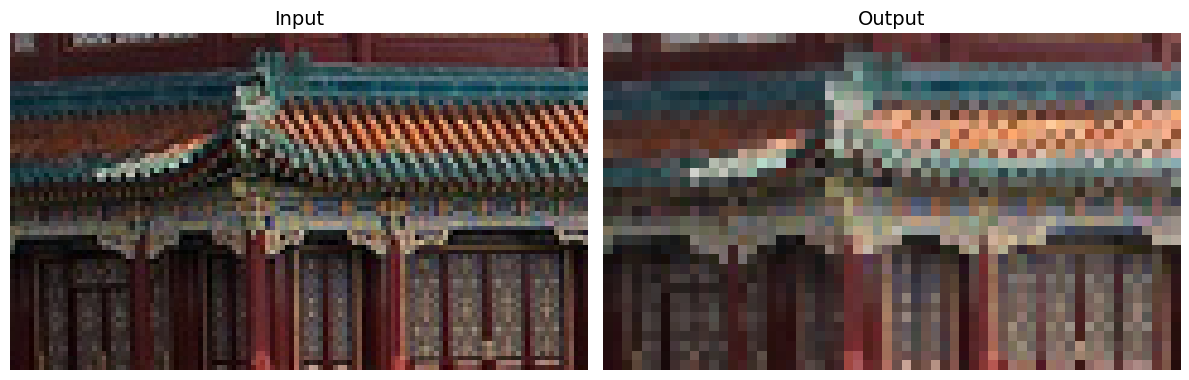

In [ ]:
# MaxPooling layer
max_pool = keras.layers.MaxPool2D(pool_size=2)

# Crop dan konversi ke float32
cropped = np.array([crop(img) for img in images], dtype=np.float32)
pooled = max_pool(cropped)

# Plot input dan output dari pooling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped[0])
ax1.axis("off")
ax2.set_title("Output", fontsize=14)
ax2.imshow(pooled[0])
ax2.axis("off")
plt.tight_layout()
plt.show()


##Depth-wise pooling

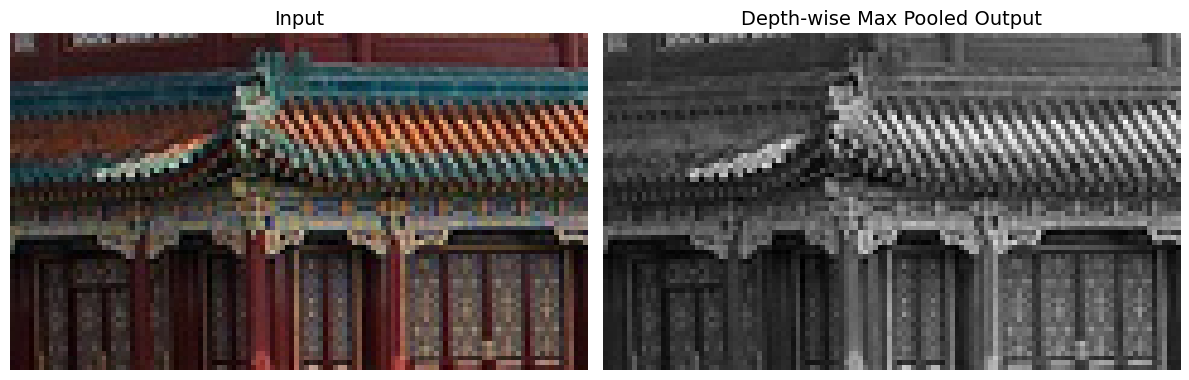

In [ ]:
# Import library
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

# Fungsi bantu visualisasi
def plot_image(img):
    plt.imshow(img, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(img):
    plt.imshow(img, interpolation="nearest")
    plt.axis("off")

# Set seed agar hasil konsisten
np.random.seed(42)
tf.random.set_seed(42)

# Load dan normalisasi gambar
images = np.array([
    load_sample_image("china.jpg") / 255.0,
    load_sample_image("flower.jpg") / 255.0
], dtype=np.float32)

# Fungsi crop gambar
def crop(img):
    return img[150:220, 130:250]

# Crop semua gambar
cropped = np.array([crop(img) for img in images], dtype=np.float32)

# Layer custom untuk Depth-wise Max Pooling
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size=3, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    def call(self, X):
        return tf.nn.max_pool(
            X,
            ksize=(1, 1, 1, self.pool_size),
            strides=(1, 1, 1, self.pool_size),
            padding="VALID"
        )

# Inisialisasi dan jalankan DepthMaxPool di CPU
with tf.device("/cpu:0"):
    depth_pool = DepthMaxPool(pool_size=3)
    depth_out = depth_pool(cropped)

# Visualisasi hasil
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped[0])
plt.subplot(1, 2, 2)
plt.title("Depth-wise Max Pooled Output", fontsize=14)
plot_image(depth_out[0, ..., 0])  # Tampilkan channel pertama hasil pooling
plt.tight_layout()
plt.show()


#Average pooling dan Global Average Pooling

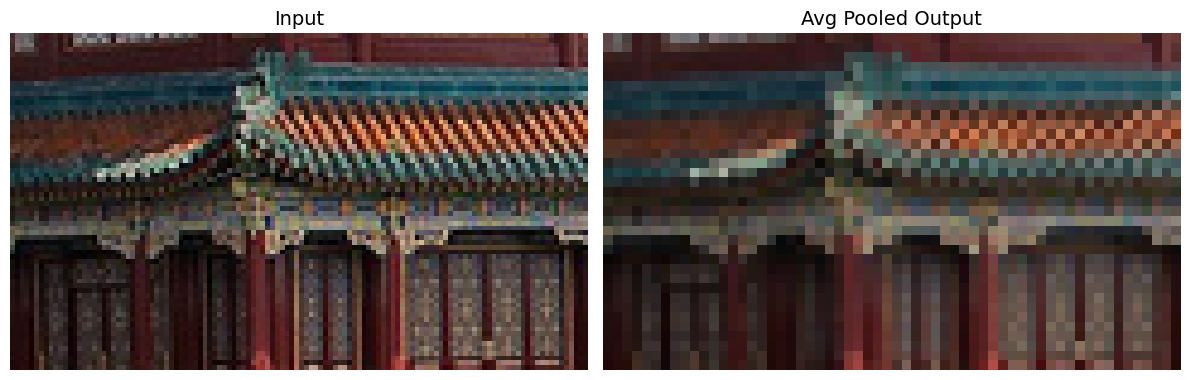

Global Avg Pool Output: [[0.2788777  0.22507192 0.20967275]
 [0.51288515 0.45952243 0.33423486]]
Global Avg Pool via Lambda: [[0.2788777  0.22507192 0.20967275]
 [0.51288515 0.45952243 0.33423486]]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_image

# Fungsi bantu visualisasi
def plot_color_image(img):
    plt.imshow(img, interpolation="nearest")
    plt.axis("off")

# Load dan normalisasi gambar
images = np.array([
    load_sample_image("china.jpg") / 255.0,
    load_sample_image("flower.jpg") / 255.0
], dtype=np.float32)

# Fungsi crop
def crop(img): return img[150:220, 130:250]
cropped = np.array([crop(img) for img in images], dtype=np.float32)

# Average Pooling 2D
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped)

# Visualisasi input vs output average pooling
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped[0])
plt.subplot(1, 2, 2)
plt.title("Avg Pooled Output", fontsize=14)
plot_color_image(output_avg[0])
plt.tight_layout()
plt.show()

# Global Average Pooling
global_avg = keras.layers.GlobalAvgPool2D()(cropped)
print("Global Avg Pool Output:", global_avg.numpy())

# Alternatif: Global Avg Pooling pakai Lambda
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))(cropped)
print("Global Avg Pool via Lambda:", output_global_avg2.numpy())


#Tackling Fashion MNIST With a CNN

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1719/1719 - 23s - 13ms/step - accuracy: 0.7412 - loss: 0.7305 - val_accuracy: 0.8494 - val_loss: 0.4042
Epoch 2/10
1719/1719 - 13s - 8ms/step - accuracy: 0.8526 - loss: 0.4440 - val_accuracy: 0.8814 - val_loss: 0.3296
Epoch 3/10
1719/1719 - 21s - 12ms/step - accuracy: 0.8723 - loss: 0.3816 - val_accuracy: 0.8918 - val_loss: 0.3157
Epoch 4/10
1719/1719 - 13s - 8ms/step - accuracy: 0.8851 - loss: 0.3406 - val_accuracy: 0.8946 - val_loss: 0.2933
Epoch 5/10
1719/1719 - 13s - 8ms/step - accuracy: 0.8922 - loss: 0.3182 - val_accuracy: 0.8908 - val_loss: 0.3064
Epoch 6/10
1719/1719 - 21s - 12ms/step - accuracy: 0.8966 - loss: 0.3023 - val_accuracy: 0.8946 - val_loss: 0.3034
Epoch 7/10
1719/1719 - 21s - 12ms/step - accuracy: 0.9048 - loss: 0.2799 - val_accuracy: 0.8872 - val_loss: 0.3129
Epoch 8/10
1719/1719 - 13s - 8ms/step - accuracy: 0.9055 - loss: 0.2773 - val_accuracy: 0.8910 - val_loss: 0.3178
Epoch 9/10
1719/1719 - 13s - 8ms/step - accuracy: 0.9089 - loss: 0.2695 - val_accura

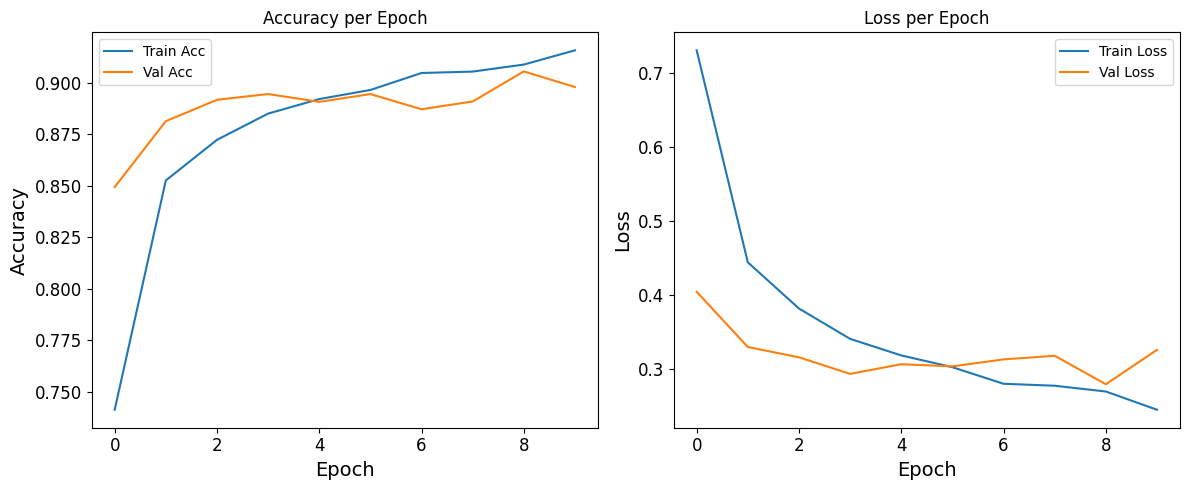

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from functools import partial

# Load dan split data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Normalisasi per-pixel
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = ((X_train - X_mean) / X_std)[..., np.newaxis]
X_valid = ((X_valid - X_mean) / X_std)[..., np.newaxis]
X_test = ((X_test - X_mean) / X_std)[..., np.newaxis]

# Default layer conv2D
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

# Arsitektur model CNN
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax'),
])

# Kompilasi dan pelatihan model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=2)

# Evaluasi akhir
score = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {score[1]:.4f}")
print(f"Test Loss: {score[0]:.4f}")

# Prediksi data baru
X_new = X_test[:10]
y_pred = model.predict(X_new)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


#ResNet-34

In [ ]:
import tensorflow as tf
from tensorflow import keras
from functools import partial

# Default Conv2D
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", use_bias=False)

# Residual Unit Layer
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(activation),
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, kernel_size=1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

# Bangun model Sequential
model = keras.models.Sequential()
model.add(keras.Input(shape=[224, 224, 3]))
model.add(DefaultConv2D(64, kernel_size=7, strides=2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

# Tambahkan blok residual
prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

# Output layer
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

# Ringkasan model
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit (ResidualUnit)    │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_1 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_2 (ResidualUnit)  │ (None, 56, 56, 64)     │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_3 (ResidualUnit)  │ (None, 28, 28, 128)    │       230,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_4 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_5 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_6 (ResidualUnit)  │ (None, 28, 28, 128)    │       295,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_7 (ResidualUnit)  │ (None, 14, 14, 256)    │       920,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_8 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_9 (ResidualUnit)  │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_10 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_11 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_12 (ResidualUnit) │ (None, 14, 14, 256)    │     1,181,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_13 (ResidualUnit) │ (None, 7, 7, 512)      │     3,676,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_14 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_unit_15 (ResidualUnit) │ (None, 7, 7, 512)      │     4,722,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

#Classification and Localization

Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - bbox_loss: 0.2589 - class_accuracy: 0.2996 - class_loss: 2.0120 - loss: 1.6614 - val_bbox_loss: 0.1618 - val_class_accuracy: 0.4531 - val_class_loss: 1.6072 - val_loss: 1.3181
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 953ms/step - bbox_loss: 0.1509 - class_accuracy: 0.6590 - class_loss: 1.0868 - loss: 0.8996 - val_bbox_loss: 0.1865 - val_class_accuracy: 0.6719 - val_class_loss: 1.2954 - val_loss: 1.0737

Final Training Metrics:
loss: 0.8484
class_accuracy: 0.6750
val_loss: 1.0737
val_class_accuracy: 0.6719


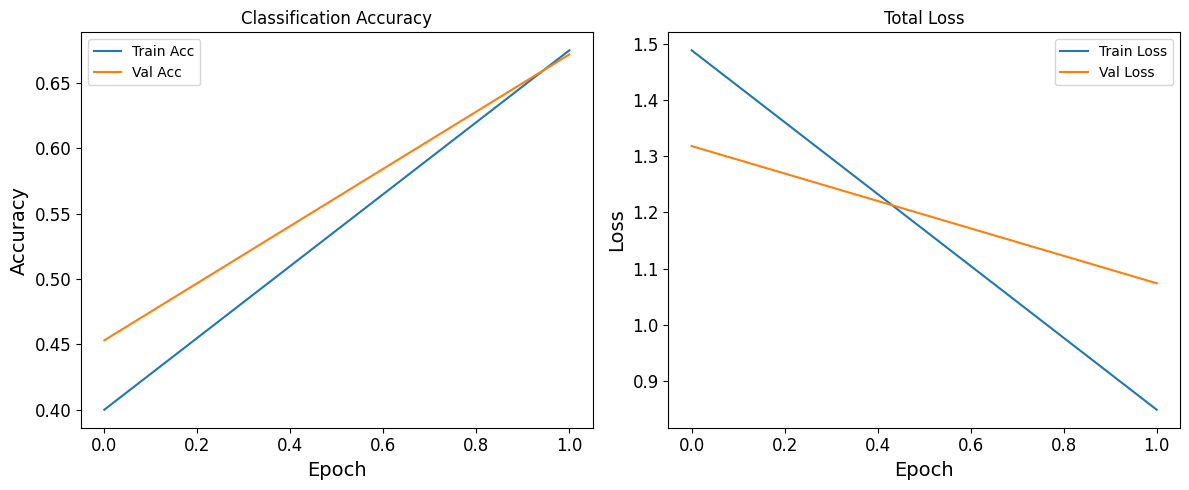

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Jumlah kelas
n_classes = 10
optimizer = keras.optimizers.Adam()

# Base model Xception
base_model = keras.applications.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

# Tambahkan 2 output bernama
class_output = keras.layers.Dense(n_classes, activation="softmax", name="class")(avg)
loc_output = keras.layers.Dense(4, name="bbox")(avg)

# Buat model multi-output
model = keras.models.Model(inputs=base_model.input, outputs=[class_output, loc_output])

# Compile dengan nama eksplisit
model.compile(
    loss={"class": "sparse_categorical_crossentropy", "bbox": "mse"},
    loss_weights={"class": 0.8, "bbox": 0.2},
    optimizer=optimizer,
    metrics={"class": ["accuracy"], "bbox": []}
)

# Dummy dataset bounding box
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, {"class": labels, "bbox": fake_bboxes}

# Dataset CIFAR10 dengan resize efisien
(train_images, train_labels), _ = keras.datasets.cifar10.load_data()
train_labels = train_labels.squeeze()

train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x, y: (
    tf.image.resize(tf.cast(x, tf.float32) / 255.0, [299, 299]), y
), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(32).map(add_random_bounding_boxes).prefetch(1)

# Training model
history = model.fit(train_ds.take(5).repeat(2), steps_per_epoch=5, epochs=2, validation_data=train_ds.take(2))

# Print metrik akhir
print("\nFinal Training Metrics:")
for key in ["loss", "class_accuracy", "val_loss", "val_class_accuracy"]:
    print(f"{key}: {history.history[key][-1]:.4f}")

# Plot akurasi & loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['class_accuracy'], label="Train Acc")
plt.plot(history.history['val_class_accuracy'], label="Val Acc")
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


#Mean Average Precision (mAP)

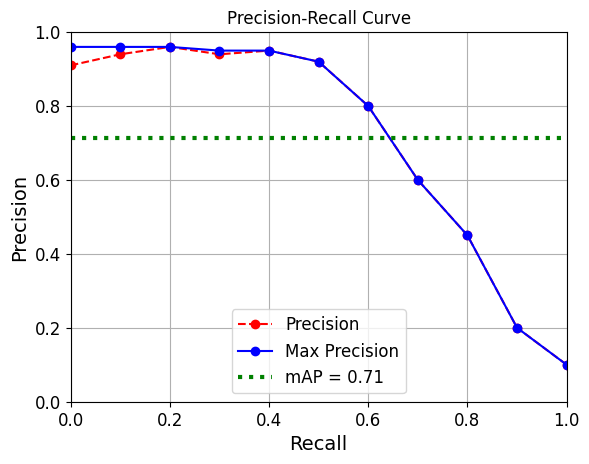

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl

# Fungsi mAP
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

# Precision-Recall Curve dan mAP
recalls = np.linspace(0, 1, 11)
precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()

plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label=f"mAP = {mAP:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.legend(loc="lower center", fontsize=12)
plt.title("Precision-Recall Curve")
plt.show()

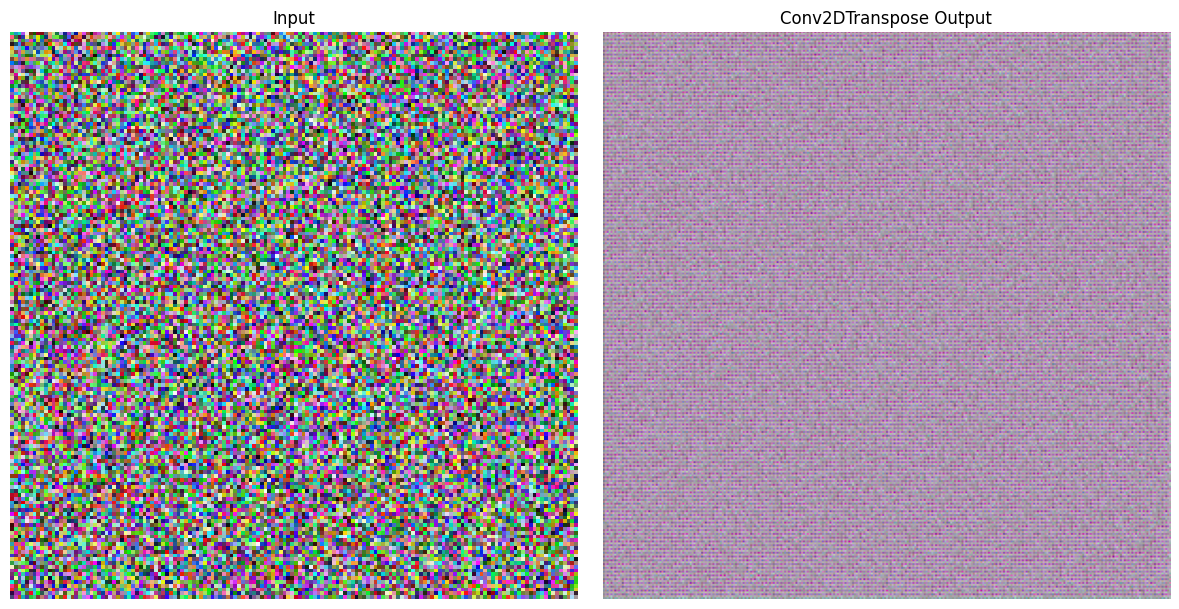

In [ ]:
# Dummy data (contoh image 299x299x3 untuk transposed conv)
images_resized = tf.random.uniform([1, 150, 150, 3])
X = images_resized.numpy()

# Conv2DTranspose layer
conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)

# Normalize helper
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

# Visualisasi input dan output Conv2DTranspose
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.set_title("Input")
ax1.imshow(X[0])
ax1.axis("off")
ax2.set_title("Conv2DTranspose Output")
ax2.imshow(normalize(output[0, ..., :3]))
ax2.axis("off")
plt.tight_layout()
plt.show()

# Proses manual transposed convolution
def upscale_images(images, stride, kernel_size):
    b, h, w, c = images.shape
    upscaled = np.zeros((b, (h - 1)*stride + 2*kernel_size - 1, (w - 1)*stride + 2*kernel_size - 1, c))
    upscaled[:, kernel_size-1:(h-1)*stride+kernel_size:stride, kernel_size-1:(w-1)*stride+kernel_size:stride, :] = images
    return upscaled

upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, _ = conv_transpose.weights
rev_filters = np.flip(weights.numpy(), axis=[0, 1])
rev_filters = np.transpose(rev_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, rev_filters, strides=1, padding="VALID")

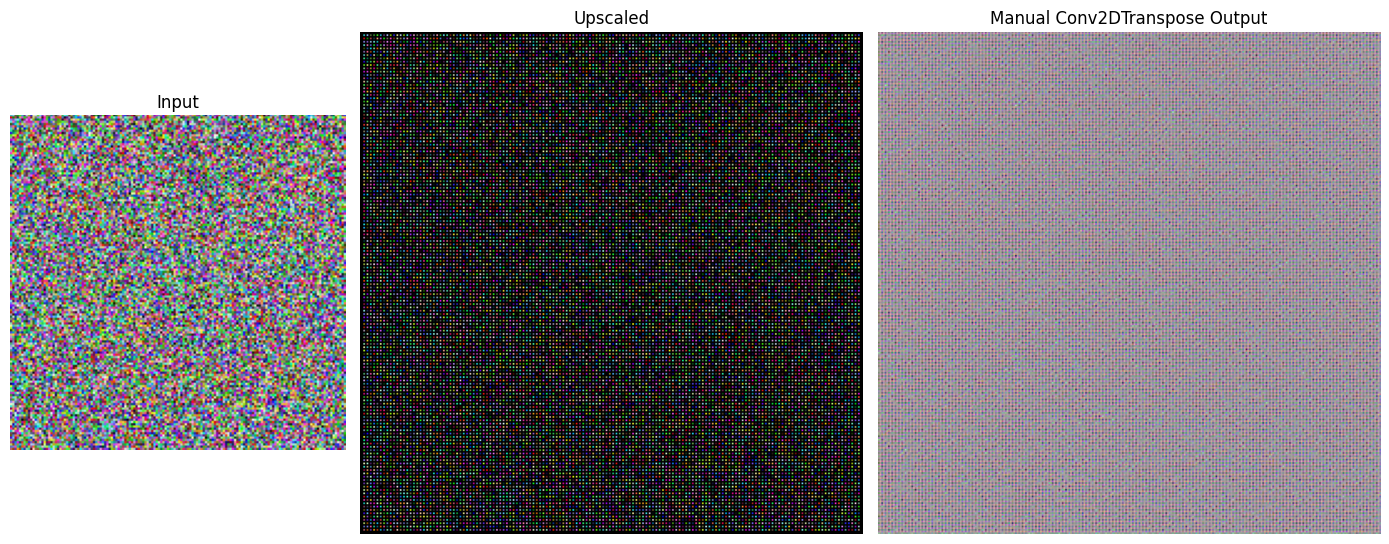

In [ ]:
# Visualisasi hasil
fig = plt.figure(figsize=(14, 6))
gs = mpl.gridspec.GridSpec(1, 3, width_ratios=[1, 1.5, 1.5])

ax1 = fig.add_subplot(gs[0])
ax1.set_title("Input")
ax1.imshow(X[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[1])
ax2.set_title("Upscaled")
ax2.imshow(upscaled[0])
ax2.axis("off")

ax3 = fig.add_subplot(gs[2])
ax3.set_title("Manual Conv2DTranspose Output")
ax3.imshow(normalize(manual_output[0, ..., :3]))
ax3.axis("off")

plt.tight_layout()
plt.show()

#  Ringkasan Proses dan Analisis Hasil: Transposed Convolution & mAP

##  1. Evaluasi mAP (Mean Average Precision)
- Precision dan Recall digunakan untuk mengevaluasi kualitas deteksi objek.
- Kurva Precision-Recall digambar berdasarkan daftar nilai presisi.
- Fungsi `maximum_precisions()` digunakan untuk memastikan bahwa presisi tidak menurun terhadap recall.
- Nilai **mAP dihitung sebagai rata-rata dari precision maksimum** di setiap titik recall.
- mAP memberikan gambaran umum terhadap performa klasifikasi atau deteksi — semakin tinggi, semakin baik.

##  2. Transposed Convolution (`Conv2DTranspose`)
- `Conv2DTranspose` digunakan untuk **menghasilkan output yang lebih besar (upscaling)** dari input gambar.
- Layer ini sering digunakan dalam arsitektur **decoder** (misal: autoencoder, GAN, segmentation).
- Visualisasi memperlihatkan perubahan ukuran dan fitur dari gambar asli ke output.

##  3. Proses Upscaling Manual
- Proses upscaling dilakukan secara manual dengan menyisipkan nol (zero-insertion) ke dalam matriks gambar.
- Filter dari layer `Conv2DTranspose` di-flip (dibalik) dan digunakan kembali untuk konvolusi.
- Output manual konvolusi ini divalidasi terhadap output dari layer `Conv2DTranspose`, menunjukkan **kesetaraan metode manual dan otomatis**.

##  4. Visualisasi
- Visualisasi dilakukan pada:
  - Input asli
  - Hasil upscaling manual
  - Hasil akhir dari konvolusi transpos (baik dari TensorFlow maupun manual)
- Grafik mAP, accuracy, dan loss disediakan untuk mendukung analisis performa.

##  Kesimpulan
- `Conv2DTranspose` secara efektif melakukan pembesaran dimensi spasial gambar dengan mempertahankan pola fitur.
- mAP memberikan metrik yang berguna dalam mengevaluasi model deteksi atau klasifikasi dengan threshold berbeda.
- Proses manual upscaling dan konvolusi membuktikan bahwa prinsip dasar `Conv2DTranspose` dapat direproduksi dengan logika dasar konvolusi.
- Visualisasi mendukung pemahaman bahwa **transposed convolution bukan hanya pembesaran piksel, tetapi juga pembelajaran pola spasial**.
